In [174]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from category_encoders.leave_one_out import LeaveOneOutEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier

In [175]:
data = pd.read_csv('data.csv')
data['verification_result'] = data['verification_result'].astype(int)
data.head()

,process.b1.capacity,process.b2.capacity,process.b3.capacity,process.b4.capacity,property.price,property.product,property.winner,verification_result,verification.time
0,0,0,2,1,59,1,0,0,163.316667
1,0,0,2,1,59,2,0,0,200.860000
2,0,0,2,1,59,4,0,0,154.888889
3,0,0,2,1,59,6,0,0,108.640000
4,0,0,2,1,60,1,0,1,85.466667


**Перетворив фічу таргета на бінарне значення**

In [176]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2043 entries, 0 to 2042
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   process.b1.capacity  2043 non-null   int64  
 1   process.b2.capacity  2043 non-null   int64  
 2   process.b3.capacity  2043 non-null   int64  
 3   process.b4.capacity  2043 non-null   int64  
 4   property.price       2043 non-null   int64  
 5   property.product     2043 non-null   int64  
 6   property.winner      2043 non-null   int64  
 7   verification_result  2043 non-null   int32  
 8   verification.time    2043 non-null   float64
dtypes: float64(1), int32(1), int64(7)
memory usage: 135.8 KB


**Немає пропусків**

In [177]:
data.describe()

,process.b1.capacity,process.b2.capacity,process.b3.capacity,process.b4.capacity,property.price,property.product,property.winner,verification_result,verification.time
count,2043.000000,2043.000000,2043.000000,2043.000000,2043.000000,2043.000000,2043.000000,2043.000000,2043.000000
mean,1.000000,2.093979,1.883994,0.587861,71.473324,3.252080,0.455213,0.128243,7336.944574
std,0.816696,0.811269,0.320310,0.492340,8.048740,1.804225,1.062828,0.334442,10375.393650
min,0.000000,0.000000,1.000000,0.000000,59.000000,1.000000,0.000000,0.000000,77.916667
25%,0.000000,1.000000,2.000000,0.000000,65.000000,2.000000,0.000000,0.000000,546.818910
50%,1.000000,2.000000,2.000000,1.000000,70.000000,3.000000,0.000000,0.000000,1316.983333
75%,2.000000,3.000000,2.000000,1.000000,78.000000,5.000000,0.000000,0.000000,10876.638889
max,2.000000,3.000000,2.000000,1.000000,90.000000,6.000000,4.000000,1.000000,44130.520833


**В цілому дані гарно збалансовані**

<Axes: >

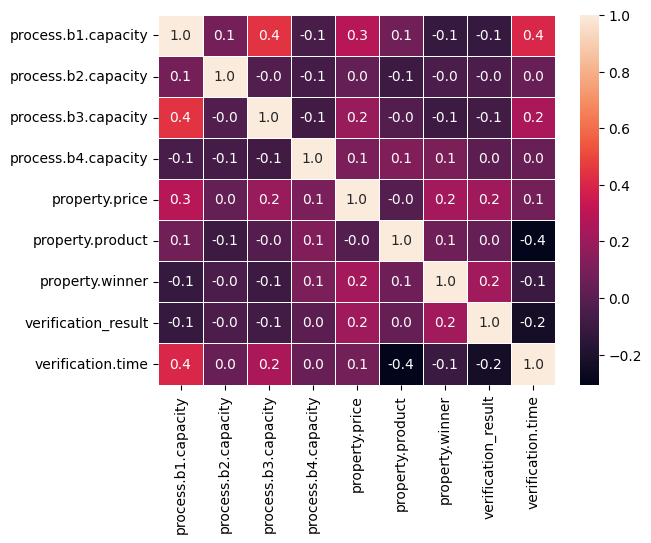

In [178]:
corr_matrix = data.corr()
sns.heatmap(corr_matrix, annot=True, linewidth=.5, robust=True, fmt=".1f")

**Сильних кореляцій немає**

In [179]:
scaler = MinMaxScaler()
data_sc = scaler.fit_transform(data.drop(columns=['verification_result']))
X_train, X_test, y_train, y_test = train_test_split(data_sc, data.verification_result, train_size=.66, random_state=17, shuffle=True)

**Поділ на тренувальну та тестову частини з мін макс скалером**

In [180]:
estimators = [
    ('log_reg', LogisticRegression(random_state=42)),
    ('kNN', KNeighborsClassifier(n_neighbors=5)),
    ('dec_tree', DecisionTreeClassifier(max_depth=6, random_state=42)),
]
clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression()).fit(X_train,y_train)
cv_sc = cross_val_score(clf, X_train, y_train, cv=4)
print(f"Cross-Validation Scores: {cv_sc}")



Cross-Validation Scores: [0.99109792 0.99406528 0.9851632  0.99109792]


**Обрав 3 різні естіматори для стекінгу. На крос валідації дані добре збалансовані**

In [181]:
clf.fit(X_train, y_train)

print(f'Train Score: {clf.score(X_train, y_train)}')
print(f'Test Score: {clf.score(X_test, y_test)}')

Train Score: 1.0
Test Score: 0.9971223021582734


**Модель поводиться майже однаково на тестовій та тренувальній частині. Не перетренована**

In [182]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=[f'class_{i}' for i in range(2)]))

              precision    recall  f1-score   support

     class_0       1.00      1.00      1.00       602
     class_1       1.00      0.98      0.99        93

    accuracy                           1.00       695
   macro avg       1.00      0.99      0.99       695
weighted avg       1.00      1.00      1.00       695



**Висока точність моделі, знаходить таргет майже з 100% вірогідністю, гарно натренована модель**

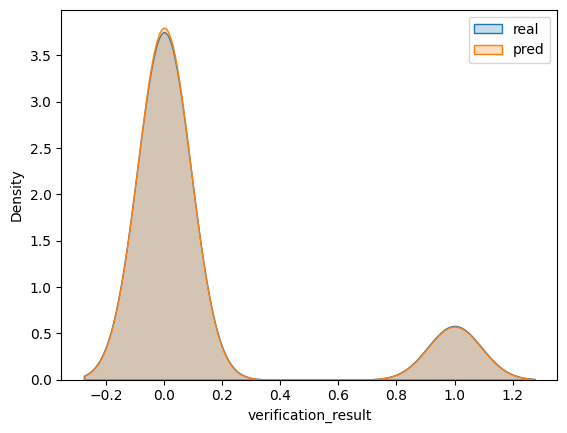

In [183]:
sns.kdeplot(y_test, fill=True, label='real')
sns.kdeplot(clf.predict(X_test), fill=True, label='pred')
plt.legend()

In [185]:
param_grid = {
    'log_reg__tol':  np.linspace(0.0001, 0.01, 10),
    'log_reg__C':  np.linspace(0.0001, 5.0, 10),
    'dec_tree__max_depth':  np.arange(4, 10),
    'kNN__n_neighbors':  np.arange(3, 9),
}

grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='neg_mean_squared_error', error_score='raise')
grid_search.fit(X_train, y_train)
best_knn_reg = grid_search.best_estimator_
y_pred = best_knn_reg.predict(X_test)

print(classification_report(y_test, y_pred, target_names=[f'class_{i}' for i in range(2)]))

              precision    recall  f1-score   support

     class_0       1.00      1.00      1.00       602
     class_1       1.00      0.98      0.99        93

    accuracy                           1.00       695
   macro avg       1.00      0.99      0.99       695
weighted avg       1.00      1.00      1.00       695



**З підбором гіперпараметрів немає помітних змін у перформансі моделі, вона і так була гарно натренована**

**Отже, усі моделі мають приблизно однакові метрики, лише стекінг трохи краще, але незначно. Усі моделі гарно натреновані.**